This notebook is actually a copy of `gaiadr2_icrf1_comparison.ipynb`, but I limit the Gaia sample to $G<18.7$.

In [1]:
from astropy.table import Table, join, Column
from astropy import units as u
import astropy.coordinates as coord
from astropy.coordinates import SkyCoord
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
# %config InlineBackend.figure_format = "svg"

# My modules
from my_progs.catalog.vsh_deg1_cor import vsh_deg01_fitting
from my_progs.catalog.vsh_deg2_cor import vsh_deg02_fitting, residual_calc02
from my_progs.catalog.pos_diff import nor_sep_calc, pos_diff_calc
from my_progs.catalog.pos_err import pos_err_calc
from my_progs.catalog.write_output import print_vsh1_corr, print_vsh2_corr
from my_progs.stat_func.rms_calc import rms_calc

In [2]:
# Read Gaia DR2 IERS quasar data
from my_progs.catalog.read_gaia import read_dr2_iers
gaiadr2 = read_dr2_iers()

# A selection on the G magnitude
bgt_mask = (gaiadr2["phot_g_mean_mag"] >= 18.7)
gaiadr2 = gaiadr2[bgt_mask]

# Read ICRF1 catalog
from my_progs.catalog.read_icrf import read_icrf1
icrf1 = read_icrf1()

# Crossmatch among these three catalogs
common_source = join(icrf1, gaiadr2, keys="iers_name", table_names=["icrf1", "gaiadr2"]) 

In [3]:
# The positonal offset for common sources between GaiaDR2 and ICRF2.
[dRA, dDC, dRA_err, dDC_err, dRA_dDC_cov,
 ang_sep, X_a, X_d, X] = pos_diff_calc(
    common_source["ra_icrf1"], common_source["ra_err_icrf1"],
    common_source["dec_icrf1"], common_source["dec_err_icrf1"],
    common_source["ra_dec_corr_icrf1"],
    common_source["ra_gaiadr2"], common_source["ra_err_gaiadr2"],
    common_source["dec_gaiadr2"], common_source["dec_err_gaiadr2"],
    common_source["ra_dec_corr_gaiadr2"])

common_source.add_columns(
    [dRA, dDC, dRA_err, dDC_err, dRA_dDC_cov, ang_sep, X_a, X_d, X],
    names=["dra", "ddec", "dra_err", "ddec_err", "dra_ddec_cov",
           "ang_sep", "nor_dra",  "nor_ddec", "nor_sep"])

common_source["dra"].unit = u.mas
common_source["ddec"].unit = u.mas
common_source["dra_err"].unit = u.mas

In [4]:
common_source

icrf_name,iers_name,type,ra_icrf1,dec_icrf1,si_s,si_x,ra_err_icrf1,dec_err_icrf1,pos_err_icrf1,ra_dec_corr_icrf1,mean_obs,beg_obs,end_obs,nb_sess,nb_del,source_id,ra_gaiadr2,ra_err_gaiadr2,dec_gaiadr2,dec_err_gaiadr2,pos_err_gaiadr2,parallax,parallax_err,pmra,pmra_err,pmdec,pmdec_err,ra_dec_corr_gaiadr2,ra_parallax_corr,ra_pmra_corr,ra_pmdec_corr,dec_parallax_corr,dec_pmra_corr,dec_pmdec_corr,parallax_pmra_corr,parallax_pmdec_corr,pmra_pmdec_corr,phot_g_mean_mag,phot_bp_mean_mag,phot_rp_mean_mag,dra,ddec,dra_err,ddec_err,dra_ddec_cov,ang_sep,nor_dra,nor_ddec,nor_sep
,,,deg,deg,,,mas,mas,mas,,,,,,,,deg,mas,deg,mas,mas,mas,mas,mas / yr,mas / yr,mas / yr,mas / yr,,,,,,,,,,,mag,mag,mag,mas,mas,mas,mas,,deg,deg,deg,deg
str16,str8,str1,float64,float64,int64,int64,float64,float64,float64,float64,float64,float64,float64,int64,int64,int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float64,float64,float64,float64,float64,float64,float64,float64,float64
J000435.6-473619,0002-478,C,1.1485649833333333,-47.60544543333334,--,--,0.7989651584169764,0.97,0.970368462441557,0.019,2449436.0,2449331.0,2449525.2,3,7,4978016560925910400,1.1485644787260738,0.32535001967377664,-47.60544549244506,0.38175267275937685,0.4046925099699907,-0.394507921304075,0.5551341682993441,0.10766725569112054,0.5623357858130931,-0.2990603581366252,0.6935629455335646,-0.2602696,0.38209838,-0.3261622,-0.043664124,-0.36382514,0.12289763,-0.07530141,-0.16826801,-0.2654429,-0.06584475,19.847563,19.998808,19.225542,1.2248008680027802,0.21280219186792237,0.8626690904779137,1.0424179119522687,-0.01760140111750944,1.2431500066863033,1.4197806337587076,0.20414287727402977,1.4386070836147198
J001101.2-261233,0008-264,C,2.7551947999999995,-26.209271349999998,--,--,0.47102313058519535,0.39999999999999997,0.5264251833925705,-0.427,2448892.9,2447686.6,2449791.2,7,38,2335249516418438272,2.7551948192602023,0.26474200864756736,-26.209271412091674,0.19152239774407323,0.2648242736959451,0.48838471517326665,0.33995235834184195,-0.3814735727827663,0.4874481854801042,-0.7575069949813538,0.39611172288816077,0.02380841,0.26370704,0.4832799,-0.14790614,-0.008249272,-0.09487959,0.23874593,-0.05463864,-0.37078896,0.17084321,18.927097,18.99775,18.506237,-0.06220800687458062,0.22353003288344553,0.5403250139397829,0.4434871236435608,-0.07924356848541278,0.23202480841535483,-0.11513071812276574,0.5040282365967877,0.5069793361418949
J001331.1+405137,0010+405,D,3.379709220833333,40.86031779722222,2,1,0.29495963311504103,0.33999999999999997,0.34073318132559427,-0.038,2449550.1,2448435.2,2449821.0,7,219,383084664461521536,3.379709059533647,0.30642273194190933,40.86031817758646,0.18262136689914535,0.308104947689734,0.015450318433697707,0.35624755363875243,0.7872298627334215,0.5711080651114665,-0.2178478450070414,0.2812835079111348,-0.14257787,0.3022634,-0.31667477,0.19280086,-0.09837172,0.18864177,-0.4105155,-0.2648572,0.19643839,-0.21485445,19.07663,19.004562,17.54357,0.439171349718924,-1.3693112435930743,0.4253187931635549,0.38594114013423375,-0.011789441794793543,1.4380141710860688,1.032569820045648,-3.5479794745820974,3.6326553443164165
J001611.0-001512,0013-005,C,4.046202312499999,-0.2534570388888889,--,--,0.29999706468982845,0.36999999999999994,0.438129719663334,-0.675,2448920.8,2447394.6,2449612.4,27,116,2545226894107313280,4.04620223886711,0.5199497615091785,-0.2534567177719667,0.40458852429884573,0.5693752180307423,-0.2668020919110768,0.5850124781518719,0.7958618246788018,1.2942813415451033,0.4021532440687492,0.9046718137399743,0.44188738,0.2626055,0.031097455,-0.2671943,0.13440219,-0.21924527,-0.4057419,0.058564566,-0.038882617,0.3014373,19.783754,20.087801,19.018677,0.2650758072051452,-1.1560209197902793,0.600288258519159,0.5482625958373575,0.018033683802390857,1.1860225759057974,0.44158086293251214,-2.108516846794367,2.1810905344130735
J002232.4+060

In [5]:
# Seperate the sources into the "defining ","Candidates", and "Others".
# Defining sources
mask_def = (common_source["type"] == "D")
com_def = common_source[mask_def]

# Candidate sources
mask_can = (common_source["type"] == "C")
com_can = common_source[mask_can]

# Other sources
mask_oth =  (common_source["type"] == "O")
com_oth = common_source[mask_oth]

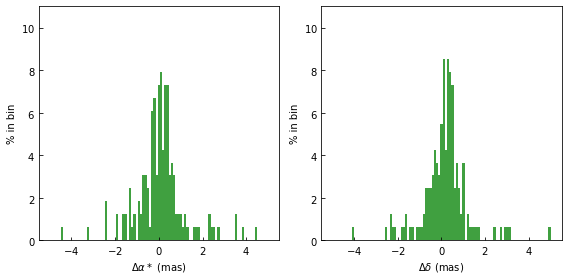

In [6]:
# Difference in RA and decl.
bins_array = np.linspace(-5, 5, 100)
weights = np.ones_like(dRA) * 100. / dRA.size

fig, (ax0, ax1) = plt.subplots(figsize=(8, 4), ncols=2)
ax0.hist(dRA, bins_array, weights=weights, facecolor="g", alpha=0.75)
ax1.hist(dDC, bins_array, weights=weights, facecolor="g", alpha=0.75)

ax0.set_yticks(np.arange(0, 11, 2))
ax1.set_yticks(np.arange(0, 11, 2))

ax0.set_ylim([0, 11])
ax1.set_ylim([0, 11])

ax0.set_xlabel("$\Delta\\alpha*$ (mas)")
ax1.set_xlabel("$\Delta\\delta$ (mas)")

ax0.set_ylabel("% in bin")
ax1.set_ylabel("% in bin")

fig.tight_layout()
plt.show()

In [7]:
std_ra = np.std(dRA)
std_dec = np.std(dDC)
_, wrms_ra, _ = rms_calc(dRA, dRA_err)
_, wrms_dec, _ = rms_calc(dDC, dDC_err)

std_ra, std_dec, wrms_ra, wrms_dec

(12.973459702927004, 5.5804640313850715, 3.0228652190243017, 2.487304801924325)

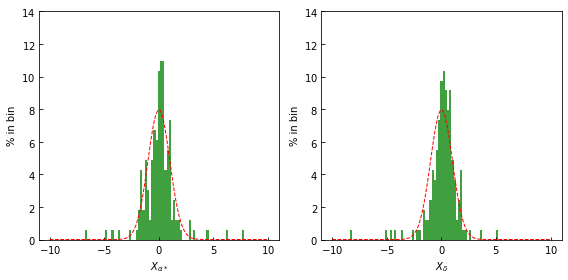

In [8]:
# Normalized difference in RA and decl.
from scipy import stats
bins_array = np.linspace(-10, 10, 100)
weights = np.ones_like(dRA) * 100. / dRA.size

# Plot the 
fig, (ax0, ax1) = plt.subplots(figsize=(8, 4), ncols=2)
ax0.hist(X_a, bins_array, weights=weights, facecolor="g", alpha=0.75)
ax1.hist(X_d, bins_array, weights=weights, facecolor="g", alpha=0.75)

ax0.set_xlabel("$X_{\\alpha*}$")
ax1.set_xlabel("$X_{\\delta}$")

ax0.set_ylim([0, 13])
ax1.set_ylim([0, 13])

ax0.set_ylabel("% in bin")
ax1.set_ylabel("% in bin")

# add a '(standard) Gaussian distribution' line
Gaussian_dist = stats.norm.pdf(bins_array, 0, 1) * 10. / 50
ax0.plot(bins_array, Gaussian_dist * 100, "r--", linewidth=1)
ax1.plot(bins_array, Gaussian_dist * 100, "r--", linewidth=1)

ax0.set_yticks(np.arange(0, 15, 2))
ax1.set_yticks(np.arange(0, 15, 2))

fig.tight_layout()
plt.show()

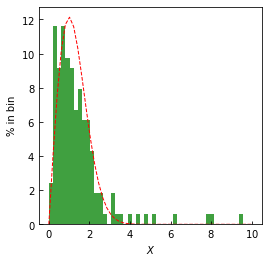

In [9]:
# Distribution of normalized separation
from scipy import stats

bins_array = np.linspace(0, 10, 50)
weights = np.ones_like(X) * 100. / X.size

fig, ax = plt.subplots(figsize=(4, 4))
ax.hist(X, bins_array, weights=weights, facecolor="g", alpha=0.75)

# add a '(standard) Rqyleigh distribution' line
rayleigh_dist = stats.rayleigh.pdf(bins_array) * 10. / 50  * 100
ax.plot(bins_array, rayleigh_dist, "r--", linewidth=1)

ax.set_xlabel("$X$")
ax.set_ylabel("% in bin")

plt.show()

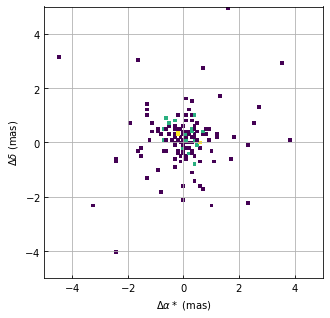

In [10]:
from matplotlib import colors

fig, ax = plt.subplots(figsize=(5, 5))

bins = np.linspace(-5, 5, 100)

# We can increase the number of bins on each axis
ax.hist2d(dRA, dDC, bins, norm=colors.LogNorm())

ax.set_xlabel("$\Delta\\alpha*$ (mas)")
ax.set_ylabel("$\Delta\\delta$ (mas)")

ax.grid(True)

plt.show()

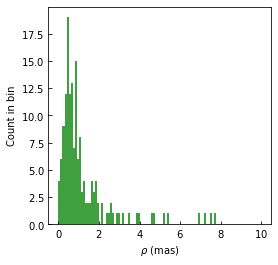

In [11]:
# Distribution of angular separation
bins_array = np.linspace(0, 10, 100)

fig, ax = plt.subplots(figsize=(4, 4))
ax.hist(ang_sep, bins_array, facecolor="g", alpha=0.75)

ax.set_xlabel("$\\rho$ (mas)")
ax.set_ylabel("Count in bin")

plt.show()

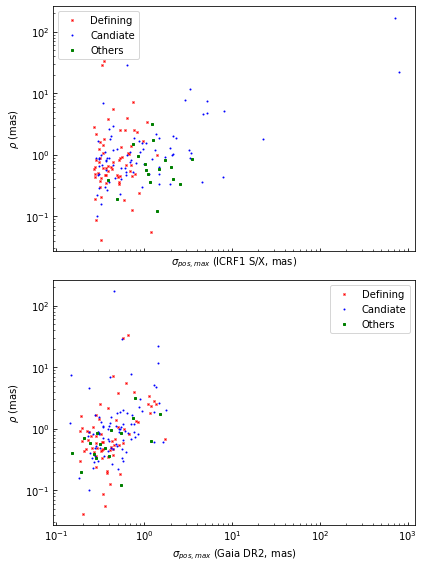

In [12]:
# Angular position difference vs. positional uncertainty
fig, (ax0, ax1) = plt.subplots(figsize=(6, 8), nrows=2, sharex=True)

ax0.plot(com_def["pos_err_icrf1"],
         com_def["ang_sep"], "rx", ms=2, label="Defining")
ax1.plot(com_def["pos_err_gaiadr2"],
         com_def["ang_sep"], "rx", ms=2, label="Defining")

ax0.plot(com_can["pos_err_icrf1"],
         com_can["ang_sep"], "b.", ms=2, label="Candiate")
ax1.plot(com_can["pos_err_gaiadr2"],
         com_can["ang_sep"], "b.", ms=2, label="Candiate")

ax0.plot(com_oth["pos_err_icrf1"],
         com_oth["ang_sep"], "gs", ms=2, label="Others")
ax1.plot(com_oth["pos_err_gaiadr2"],
         com_oth["ang_sep"], "gs", ms=2, label="Others")

ax0.set_xscale("log")
ax0.set_yscale("log")
ax1.set_xscale("log")
ax1.set_yscale("log")

ax0.set_xlabel("$\sigma_{pos,max}$ (ICRF1 S/X, mas)")
ax0.set_ylabel("$\\rho$ (mas)")
ax1.set_xlabel("$\sigma_{pos,max}$ (Gaia DR2, mas)")
ax1.set_ylabel("$\\rho$ (mas)")


ax0.legend()
ax1.legend()

fig.tight_layout()
plt.show()

Then I investigate the systematics through the 16-parameters transformation.

In [13]:
# Try with all the sources
# Transform columns into np.array
dra = np.array(common_source["dra"])
ddec = np.array(common_source["ddec"])
dra_err = np.array(common_source["dra_err"])
ddec_err = np.array(common_source["ddec_err"])
ra_rad = np.array(common_source["ra_icrf1"].to(u.radian))
dec_rad = np.array(common_source["dec_icrf1"].to(u.radian))
dra_ddec_cov = np.array(common_source["dra_ddec_cov"])

# Transformation parameters
# l_max = 1
w1_all, sig1_all, corrcoef1_all = vsh_deg01_fitting(
    dra, ddec, ra_rad, dec_rad, dra_err, ddec_err,
    cov=dra_ddec_cov, elim_flag="None")

# l_max = 2
w2_all, sig2_all, corrcoef2_all = vsh_deg02_fitting(
    dra, ddec, ra_rad, dec_rad, dra_err, ddec_err,
    cov=dra_ddec_cov, elim_flag="None")

# mas -> uas
w1 = w1_all * 1.e3
sig1 = sig1_all * 1.e3
w2 = w2_all * 1.e3
sig2 = sig2_all * 1.e3

# Print results
print("Estimates (%6d sources)\n"
      "----------------------------------------------"
      "----------------------------------------------\n"
      "               Rotation [uas]                 "
      "                  Glide [uas]               \n"
      "               x             y             z"
      "               x             y             z\n"
      "----------------------------------------------"
      "----------------------------------------------\n"
      "l_max=1  %+4.0f +/- %3.0f  %+4.0f +/- %3.0f  %+4.0f +/- %3.0f  "
      "  %+4.0f +/- %3.0f  %+4.0f +/- %3.0f  %+4.0f +/- %3.0f\n"
      "l_max=2  %+4.0f +/- %3.0f  %+4.0f +/- %3.0f  %+4.0f +/- %3.0f  "
      "  %+4.0f +/- %3.0f  %+4.0f +/- %3.0f  %+4.0f +/- %3.0f\n"
      "----------------------------------------------"
      "----------------------------------------------\n" %
      (dra.size, w1[3], sig1[3], w1[4], sig1[4], w1[5], sig1[5],
       w1[0], sig1[0], w1[1], sig1[1], w1[2], sig1[2],
       w2[3], sig2[3], w2[4], sig2[4], w2[5], sig2[5],
       w2[0], sig2[0], w2[1], sig2[1], w2[2], sig2[2]))

quad_names = Column(["ER22", "EI22", "ER21", "EI21", "E20",
                     "MR22", "MI22", "MR21", "MI21", "M20"])
t_quad = Table([quad_names, w2[6:], sig2[6:]], names=["Quadrupolar term", "Estimate", "Error"])
t_quad["Estimate"].format = "%5.0f"
t_quad["Error"].format = "%5.0f"
print(t_quad)

print("Correlation coefficient between parameters in 'l_max=1' fit")
print_vsh1_corr(corrcoef1_all, deci_digit=1, included_one=False)

print("Correlation coefficient between parameters in 'l_max=2' fit")
print_vsh2_corr(corrcoef2_all, deci_digit=1, included_one=False)

Estimates (   164 sources)
--------------------------------------------------------------------------------------------
               Rotation [uas]                                   Glide [uas]               
               x             y             z               x             y             z
--------------------------------------------------------------------------------------------
l_max=1  +134 +/- 263  +665 +/- 264  -133 +/- 269    -154 +/- 252  +306 +/- 269  +309 +/- 274
l_max=2  +204 +/- 279  +722 +/- 286  -223 +/- 301    -211 +/- 264  +372 +/- 293  +266 +/- 311
--------------------------------------------------------------------------------------------

Quadrupolar term Estimate Error
---------------- -------- -----
            ER22      -50   193
            EI22      -74   188
            ER21      227   340
            EI21     -369   345
             E20      139   331
            MR22      -33   198
            MI22       25   189
            MR21      232   348
     

In [14]:
# The last step is to save the 16 transformation parameters for further use.

vsh2_names = Column(["D1", "D2", "D3",
                     "R1", "R2", "R3",
                     "ER22", "EI22", "ER21", "EI21", "E20",
                     "MR22", "MI22", "MR21", "MI21", "M20"])
t_vsh2 = Table([vsh2_names, w2, sig2], names=[
               "Names", "Estimate", "Error"])
t_vsh2["Estimate"].format = "%5.0f"
t_vsh2["Error"].format = "%5.0f"
t_vsh2["Estimate"].unit = u.uas
t_vsh2["Error"].unit = u.uas
t_vsh2.write("../logs/icrf1_gaiadr2_fnt_vsh02_all.log",
             format="ascii", overwrite=True)

For a `clean` sample, I re-estimate the parameters.

In [15]:
# Remove the outlier (consider the normalized separation)
N = len(common_source)
X0 = np.sqrt(np.log(N) * 2)
# X0 = 3.41

print("There are %d sources.\n"
      "When X >= %.2f, the number of the outlier is smaller than 1." % (N, X0))

mask = ((common_source["nor_sep"] <= X0)
        & (common_source["ang_sep"] < 10))

# Table of a clean sample
com_clean = common_source[mask]
N1 = len(com_clean)
print("After elimination, there are %d sources in the clean sample." % N1)
print("The outlier rate is %.0f%%." % ((N-N1)/N*100))

There are 164 sources.
When X >= 3.19, the number of the outlier is smaller than 1.
After elimination, there are 147 sources in the clean sample.
The outlier rate is %10


In [16]:
# Transform columns into np.array
dra = np.array(com_clean["dra"])
ddec = np.array(com_clean["ddec"])
dra_err = np.array(com_clean["dra_err"])
ddec_err = np.array(com_clean["ddec_err"])
ra_rad = np.array(com_clean["ra_icrf1"].to(u.radian))
dec_rad = np.array(com_clean["dec_icrf1"].to(u.radian))
dra_ddec_cov = np.array(com_clean["dra_ddec_cov"])

In [17]:
# Transformation parameters
# l_max = 1
w1_cln, sig1_cln, corrcoef1_cln = vsh_deg01_fitting(
    dra, ddec, ra_rad, dec_rad, dra_err, ddec_err,
    cov=dra_ddec_cov, elim_flag="None")

# l_max = 2
w2_cln, sig2_cln, corrcoef2_cln = vsh_deg02_fitting(
    dra, ddec, ra_rad, dec_rad, dra_err, ddec_err,
    cov=dra_ddec_cov, elim_flag="None")

# mas -> uas
w1 = w1_cln * 1.e3
sig1 = sig1_cln * 1.e3
w2 = w2_cln * 1.e3
sig2 = sig2_cln * 1.e3

# Print results
print("Estimates (%6d sources)\n"
      "----------------------------------------------"
      "----------------------------------------------\n"
      "               Rotation [uas]                 "
      "                  Glide [uas]               \n"
      "               x             y             z"
      "               x             y             z\n"
      "----------------------------------------------"
      "----------------------------------------------\n"
      "l_max=1  %+4.0f +/- %3.0f  %+4.0f +/- %3.0f  %+4.0f +/- %3.0f  "
      "  %+4.0f +/- %3.0f  %+4.0f +/- %3.0f  %+4.0f +/- %3.0f\n"
      "l_max=2  %+4.0f +/- %3.0f  %+4.0f +/- %3.0f  %+4.0f +/- %3.0f  "
      "  %+4.0f +/- %3.0f  %+4.0f +/- %3.0f  %+4.0f +/- %3.0f\n"
      "----------------------------------------------"
      "----------------------------------------------\n" %
      (dra.size, w1[3], sig1[3], w1[4], sig1[4], w1[5], sig1[5],
       w1[0], sig1[0], w1[1], sig1[1], w1[2], sig1[2],
       w2[3], sig2[3], w2[4], sig2[4], w2[5], sig2[5],
       w2[0], sig2[0], w2[1], sig2[1], w2[2], sig2[2]))

quad_names = Column(["ER22", "EI22", "ER21", "EI21", "E20",
                     "MR22", "MI22", "MR21", "MI21", "M20"])
t_quad = Table([quad_names, w2[6:], sig2[6:]], names=["Quadrupolar term", "Estimate", "Error"])
t_quad["Estimate"].format = "%5.0f"
t_quad["Error"].format = "%5.0f"
print(t_quad)

print("Correlation coefficient between parameters in 'l_max=1' fit")
print_vsh1_corr(corrcoef1_cln, deci_digit=1, included_one=False)

print("Correlation coefficient between parameters in 'l_max=2' fit")
print_vsh2_corr(corrcoef2_cln, deci_digit=1, included_one=False)

Estimates (   147 sources)
--------------------------------------------------------------------------------------------
               Rotation [uas]                                   Glide [uas]               
               x             y             z               x             y             z
--------------------------------------------------------------------------------------------
l_max=1   +51 +/-  54   +58 +/-  56    -7 +/-  56      +2 +/-  52  +155 +/-  57  +189 +/-  57
l_max=2   +61 +/-  58   +58 +/-  60   -22 +/-  63     -29 +/-  54  +145 +/-  62  +150 +/-  65
--------------------------------------------------------------------------------------------

Quadrupolar term Estimate Error
---------------- -------- -----
            ER22      -38    41
            EI22      -57    39
            ER21       12    72
            EI21      -81    71
             E20       15    68
            MR22       10    42
            MI22      -69    39
            MR21      132    74
     

Save the results for future use.

In [18]:
# The last step is to save the 16 transformation parameters for further use.

vsh2_names = Column(["D1", "D2", "D3",
                     "R1", "R2", "R3",
                     "ER22", "EI22", "ER21", "EI21", "E20",
                     "MR22", "MI22", "MR21", "MI21", "M20"])
t_vsh2 = Table([vsh2_names, w2, sig2], names=[
               "Names", "Estimate", "Error"])
t_vsh2["Estimate"].format = "%5.0f"
t_vsh2["Error"].format = "%5.0f"
t_vsh2["Estimate"].unit = u.uas
t_vsh2["Error"].unit = u.uas
t_vsh2.write("../logs/icrf1_gaiadr2_fnt_vsh02.log",
             format="ascii", overwrite=True)

Then I check the residuals of positional offsets.

In [19]:
# Remove the systematics
RA = np.array(common_source["ra_icrf1"].to(u.radian))
DE = np.array(common_source["dec_icrf1"].to(u.radian))

dra_ns, ddec_ns = residual_calc02(dRA, dDC, RA, DE, w2_cln)
# dra_ns, ddec_ns = residual_calc02(dRA, dDC, RA, DE, w2_all)

# Now re-calculate the normalized difference
ang_sep_ns, Xa_ns, Xd_ns, X_ns = nor_sep_calc(
    dra_ns, dRA_err, ddec_ns, dDC_err, dRA_dDC_cov/dRA_err/dDC_err)

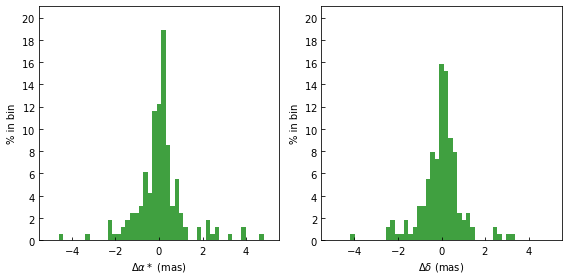

In [20]:
# Difference in RA and decl.
bins_array = np.linspace(-5, 5, 50)
weights = np.ones_like(dra_ns) * 100. / dra_ns.size

fig, (ax0, ax1) = plt.subplots(figsize=(8, 4), ncols=2)
ax0.hist(dra_ns, bins_array, weights=weights, facecolor="g", alpha=0.75)
ax1.hist(ddec_ns, bins_array, weights=weights, facecolor="g", alpha=0.75)

ax0.set_yticks(np.arange(0, 23, 2))
ax1.set_yticks(np.arange(0, 23, 2))

ax0.set_ylim([0, 21])
ax1.set_ylim([0, 21])

ax0.set_xlabel("$\Delta\\alpha*$ (mas)")
ax1.set_xlabel("$\Delta\\delta$ (mas)")

ax0.set_ylabel("% in bin")
ax1.set_ylabel("% in bin")

fig.tight_layout()
plt.show()

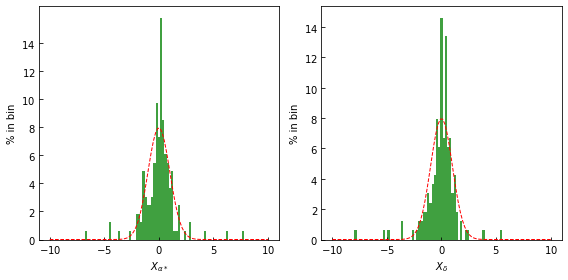

In [21]:
# Normalized difference in RA and decl.
from scipy import stats
bins_array = np.linspace(-10, 10, 100)
weights = np.ones_like(Xa_ns) * 100. / Xa_ns.size

# Plot the 
fig, (ax0, ax1) = plt.subplots(figsize=(8, 4), ncols=2)
ax0.hist(Xa_ns, bins_array, weights=weights, facecolor="g", alpha=0.75)
ax1.hist(Xd_ns, bins_array, weights=weights, facecolor="g", alpha=0.75)

ax0.set_xlabel("$X_{\\alpha*}$")
ax1.set_xlabel("$X_{\\delta}$")

ax0.set_ylabel("% in bin")
ax1.set_ylabel("% in bin")

# add a '(standard) Gaussian distribution' line
Gaussian_dist = stats.norm.pdf(bins_array, 0, 1) * 10. / 50
ax0.plot(bins_array, Gaussian_dist * 100, "r--", linewidth=1)
ax1.plot(bins_array, Gaussian_dist * 100, "r--", linewidth=1)

ax0.set_yticks(np.arange(0, 15, 2))
ax1.set_yticks(np.arange(0, 15, 2))

fig.tight_layout()
plt.show()

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

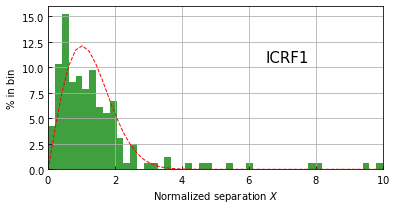

In [22]:
# Distribution of normalized separation
from scipy import stats

bins_array = np.linspace(0, 10, 50)
weights = np.ones_like(X_ns) * 100. / X_ns.size

fig, ax = plt.subplots(figsize=(6, 3))
ax.hist(X_ns, bins_array, weights=weights, facecolor="g", alpha=0.75)

# add a '(standard) Rqyleigh distribution' line
rayleigh_dist = stats.rayleigh.pdf(bins_array) * 10. / 50  * 100
ax.plot(bins_array, rayleigh_dist, "r--", linewidth=1)

ax.text(6.5, 10.5, "ICRF1", fontsize=15)

ax.set_xlim([0, 10])
ax.set_xlabel("Normalized separation $X$")
ax.set_ylabel("% in bin")
ax.grid()

plt.savefig("../plots/x_icrf1_gaiadr2_fnt.eps")

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


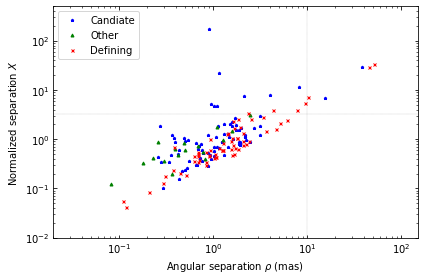

In [23]:
# Angular separation vs. normalized separation
fig, ax = plt.subplots()

ax.plot(com_can["nor_sep"], com_can["ang_sep"],
         "b*", ms=3, label="Candiate")
ax.plot(com_oth["nor_sep"], com_oth["ang_sep"],
         "g^", ms=3, label="Other")
ax.plot(com_def["nor_sep"], com_def["ang_sep"],
         "rx", ms=3, label="Defining")

ax.vlines(10, 0.01, 500, colors="k", linestyles="dashed", lw=0.1)
ax.hlines(X0, 0.02, 150, colors="k", linestyles="dashed", lw=0.1)

ax.set_xscale("log")
ax.set_yscale("log")

ax.set_ylabel("Normalized separation $X$")
ax.set_xlabel("Angular separation $\\rho$ (mas)")

ax.set_xlim([0.02, 150])
ax.set_ylim([0.01, 500])
ax.xaxis.set_ticks_position("both")
ax.yaxis.set_ticks_position("both")

ax.legend(loc="upper left")
fig.tight_layout()

plt.savefig("../plots/separation_icrf1_gaiadr2_fnt.eps")